# Predict users' gender based on Twitter text

In [1]:
# Preparing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%matplotlib inline

Basically, this project is trying to make inference about the user's gender based on the text S/He posts

In [2]:
# First, let's load the dataset
data = pd.read_csv('../input/gender-classifier-DFE-791531.csv', encoding='latin-1')
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
_unit_id                 20050 non-null int64
_golden                  20050 non-null bool
_unit_state              20050 non-null object
_trusted_judgments       20050 non-null int64
_last_judgment_at        20000 non-null object
gender                   19953 non-null object
gender:confidence        20024 non-null float64
profile_yn               20050 non-null object
profile_yn:confidence    20050 non-null float64
created                  20050 non-null object
description              16306 non-null object
fav_number               20050 non-null int64
gender_gold              50 non-null object
link_color               20050 non-null object
name                     20050 non-null object
profile_yn_gold          50 non-null object
profileimage             20050 non-null object
retweet_count            20050 non-null int64
sidebar_color            20050 non-null object
text    

So, we have 26 columns. However,columns or attributes like user_timezone are not useful for the prediction. So we need to drop some of the columns to reduce the workload.

In [3]:
# Drop unnecessary columns
data.drop (columns = ['_unit_id',
                      '_last_judgment_at',
                      'user_timezone',
                      'tweet_coord',
                      'tweet_count',
                      'tweet_created', 
                      'tweet_id',
                      'tweet_location',
                      'profileimage',
                      'created',
                      'profile_yn',
                      'profile_yn:confidence',
                      'profile_yn_gold',
                      '_golden',
                      '_unit_state',
                      '_trusted_judgments',
                      'gender_gold'
                     ], inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 9 columns):
gender               19953 non-null object
gender:confidence    20024 non-null float64
description          16306 non-null object
fav_number           20050 non-null int64
link_color           20050 non-null object
name                 20050 non-null object
retweet_count        20050 non-null int64
sidebar_color        20050 non-null object
text                 20050 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 1.4+ MB


Now we have 9 columns. Let's continue to clean the dataset.

## Clean Dataset

### 'Gender' Attribute (gender)

In [4]:
data['gender'].value_counts()
# We can see that there are 1117 unknown genders, so get rid of them

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64

So, we can see there are female, male. brand and unknown. Let's drop 'unknown', since it has nothing to do in this project 

In [5]:
drop_items_idx = data[data['gender'] == 'unknown'].index

data.drop (index = drop_items_idx, inplace = True)

data['gender'].value_counts()

female    6700
male      6194
brand     5942
Name: gender, dtype: int64

It is suggested to keep only 100% confidence of labeling Gender and get rid of those < 100% confidence.
Then let's do that

In [6]:
print ('Full data items: ', data.shape)
print ('Data with label-confidence < 100%: ', data[data['gender:confidence'] < 1].shape)

drop_items_idx = data[data['gender:confidence'] < 1].index
data.drop (index = drop_items_idx, inplace = True)
print (data['gender:confidence'].value_counts())
data.drop (columns = ['gender:confidence'], inplace = True)

Full data items:  (18933, 9)
Data with label-confidence < 100%:  (5103, 9)
1.0    13804
Name: gender:confidence, dtype: int64


### Get rid of remaining useless features

In [7]:
# let's check the data again
print (data['gender'].value_counts())

print ('---------------------------')
data.info()

female    5367
male      4653
brand     3784
Name: gender, dtype: int64
---------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13830 entries, 0 to 20049
Data columns (total 8 columns):
gender           13804 non-null object
description      11795 non-null object
fav_number       13830 non-null int64
link_color       13830 non-null object
name             13830 non-null object
retweet_count    13830 non-null int64
sidebar_color    13830 non-null object
text             13830 non-null object
dtypes: int64(2), object(6)
memory usage: 972.4+ KB


## Manipulate Text data

### Removing stop-words in Twits

In [8]:
#first, let's check the most common words
from collections import Counter

twit_vocab = Counter()
for twit in data['text']:
    for word in twit.split(' '):
        twit_vocab[word] += 1
        
        
twit_vocab.most_common(20)


[('the', 8391),
 ('and', 7979),
 ('to', 4198),
 ('I', 3232),
 ('a', 3067),
 ('of', 2751),
 ('in', 2274),
 ('you', 2176),
 ('for', 2163),
 ('The', 2022),
 ('is', 1881),
 ('on', 1623),
 ('my', 1365),
 ('it', 1208),
 ('', 1187),
 ('with', 1158),
 ('Weather', 1074),
 ('that', 1033),
 ('from', 1022),
 ('me', 1004)]

Now we can see that the most common words are meaningless words like 'the', 'and','to'. Such words are called 'stopwords', and we need to remove them for analyzing effectively.

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


False

In [10]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

twit_vocab_reduced = Counter()
for w, c in twit_vocab.items():
    if not w in stop:
        twit_vocab_reduced[w]=c

twit_vocab_reduced.most_common(20)

[('I', 3232),
 ('The', 2022),
 ('', 1187),
 ('Weather', 1074),
 ('-', 769),
 ("I'm", 651),
 ('like', 628),
 ('Get', 627),
 ('get', 571),
 ('Updates', 538),
 ('Channel.', 537),
 ('And', 489),
 ('one', 416),
 ('&amp;', 349),
 ('new', 345),
 ('love', 341),
 ('people', 315),
 ('time', 301),
 ('go', 290),
 ('know', 289)]

### Removing special characters 
Now let's move forward to remove some puctuation signs and html tags like `&amp`

In [11]:
import re

def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text

print(preprocessor('This!!@ twit :) is <b>nice</b>'))

this twit is nice :)


### Lemmatization and stemming

Now let's use Porter algorithm to do the stemming

In [12]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

print(tokenizer('Hi there, I am loving this, like with a lot of love'))
print(tokenizer_porter('Hi there, I am loving this, like with a lot of love'))

['Hi', 'there,', 'I', 'am', 'loving', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love']
['Hi', 'there,', 'I', 'am', 'love', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love']


OK, perfect!
Now, we basically finish cleaning the dataset and we could start to do some exploratory analysis work

## Exploratory data visualization

Among text data, i want to find out if other features can give me useful information or show some special characteristics.

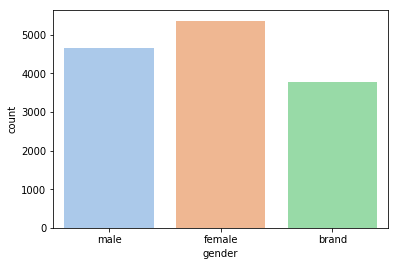

In [13]:
#Create a countplot to visualize the amount of each label
sns.countplot(data['gender'],label="Gender",palette = 'pastel')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


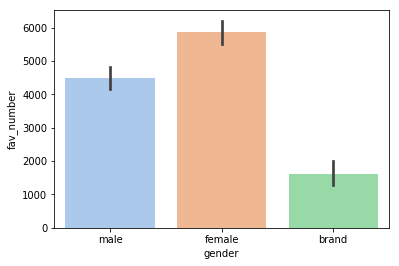

In [14]:
#Create a bar plot to visualize the amount of *favorites*
sns.barplot (x = 'gender', y = 'fav_number',data = data,palette = 'pastel')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


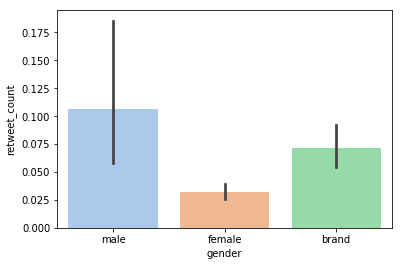

In [15]:
#Create a bar plot to visualize the amount of *retweet_count*
sns.barplot (x = 'gender', y = 'retweet_count',data = data, palette = 'pastel')

Well, there is an interesting fact: compared to Men, women are less likely to retweet

['C0DEED' 'FFFFFF' '000000' 'EEEEEE' '181A1E' 'A8C7F7' '5ED4DC']


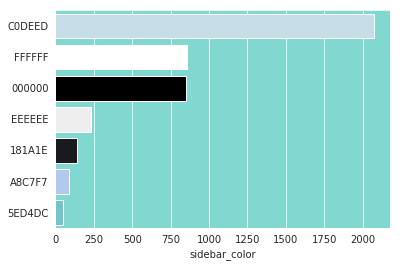

In [16]:
#we know that different genders have preferene for color,so here we can use the attribute sidebar color to make inference

#first, let's invstigate what are man's favorite side bar colors
male_top_sidebar_color = data[data['gender'] == 'male']['sidebar_color'].value_counts().head(7)
male_top_sidebar_color_idx = male_top_sidebar_color.index
male_top_color = male_top_sidebar_color_idx.values

male_top_color[2] = '000000'
print (male_top_color)
l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#81D8D0"})
sns.barplot (x = male_top_sidebar_color, y = male_top_color, palette=list(map(l, male_top_color)))

['C0DEED' 'FFFFFF' '000000' 'EEEEEE' '65B0DA' '5ED4DC' 'CC3366']


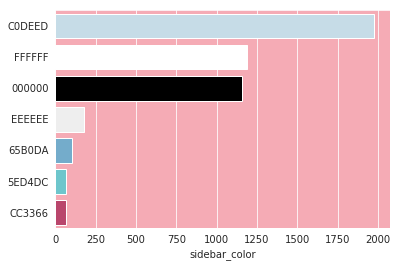

In [17]:
#next, let's invstigate what are women's favorite side bar colors

female_top_sidebar_color = data[data['gender'] == 'female']['sidebar_color'].value_counts().head(7)
female_top_sidebar_color_idx = female_top_sidebar_color.index
female_top_color = female_top_sidebar_color_idx.values

female_top_color[2] = '000000'
print (female_top_color)

l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#F5ABB5"})
sns.barplot (x = female_top_sidebar_color, y = female_top_color, palette=list(map(l, female_top_color)))

The top three colors for both men and women are the same. We may infer that the top three colors are default colors of Twitter.
Except that, there is no useful information about the side-bar color.
Let's move on, and inverstigate the link color

['0084B4' '009999' '3B94D9' '2FC2EF' 'DD2E44' '000000' 'ABB8C2']


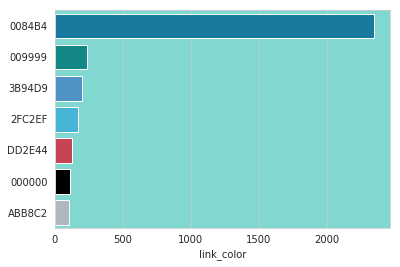

In [18]:
#first, let's invstigate what are man's favorite link colors
male_top_link_color = data[data['gender'] == 'male']['link_color'].value_counts().head(7)
male_top_link_color_idx = male_top_link_color.index
male_top_color = male_top_link_color_idx.values
male_top_color[1] = '009999'
male_top_color[5] = '000000'
print(male_top_color)

l = lambda x: '#'+x

sns.set_style("whitegrid", {"axes.facecolor": "#81D8D0"})
sns.barplot (x = male_top_link_color, y = male_top_link_color_idx, palette=list(map(l, male_top_color)))

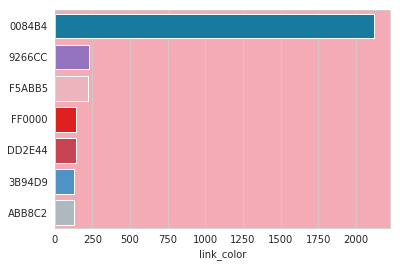

In [19]:
#next, let's invstigate what are women's favorite link colors
female_top_link_color = data[data['gender'] == 'female']['link_color'].value_counts().head(7)
female_top_link_color_idx = female_top_link_color.index
female_top_color = female_top_link_color_idx.values

l = lambda x: '#'+x

sns.set_style("whitegrid", {"axes.facecolor": "#F5ABB5"})
sns.barplot (x = female_top_link_color, y = female_top_link_color_idx, palette=list(map(l, female_top_color)))

Here is an interesting finding: except from the default link color #0084B4, women prefer colors like pink, purple,and red. men prefer colors like green and blue

## Training classification models with Tweet-text only

In this project, we are going to use Term frequency-inverse document frequency (TF-IDF) as our theory to make the classifier

In [20]:
# First, let's encode categories and convert categorical labels (gender) into numerical ones

from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()

data['gender'] = encoder.fit_transform(data['gender'].astype(str))
y = encoder.fit_transform(data['gender'])

In [21]:
# Then, we split the dataset in train and test
X = data['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

X_train.head()

8881     @catherinemep Meanwhile the Fib Dems are conti...
9998     Ella sending a video of herself eating a chees...
15622    Build a Transforming Workbench, Desk, and Stor...
9986     like i didn't do it for the reward cos if i wa...
747      The second reading was okay could've been bett...
Name: text, dtype: object

### Logistic Regression Model

In [22]:
from sklearn.linear_model import LogisticRegression

#Now let's process the text with TF-IDF
tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
#Then, let's make the classifier
clf = Pipeline([('vect', tfidf),
                ('clf', LogisticRegression(multi_class='ovr', random_state=0))])
#Fit the model
clf.fit(X_train, y_train)

#Make predictions
predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.5982164376958303
Confusion matrix:
 [[ 870  116  149    0]
 [ 214 1049  347    0]
 [ 256  577  563    0]
 [   1    5    2    0]]
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.77      0.70      1135
           1       0.60      0.65      0.62      1610
           2       0.53      0.40      0.46      1396
           3       0.00      0.00      0.00         8

   micro avg       0.60      0.60      0.60      4149
   macro avg       0.44      0.46      0.45      4149
weighted avg       0.59      0.60      0.59      4149



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Random Forest Model

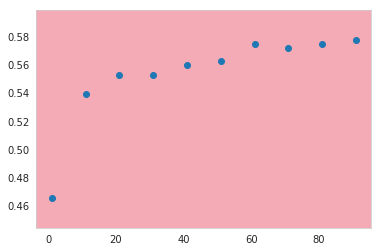

In [23]:
from sklearn.ensemble import RandomForestClassifier

n = range (1,100,10) #step 10

results = []

#let's make the classifier
for i in n:
    clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = i, random_state=0))])
#fit the model
    clf.fit(X_train, y_train)
#make predictions
    predictions = clf.predict(X_test)
    results.append(accuracy_score(y_test, predictions))
plt.grid()
plt.scatter(n, results)

So from the plot, we can see that with approximately **60** trees, Random Forest classifier starts reaching the highest performance.

In [24]:
#let's train the model and make predictons
tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)

clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = 60, random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

Accuracy: 0.5724270908652688
Confusion matrix:
 [[ 696  253  186    0]
 [ 100 1203  307    0]
 [ 150  769  476    1]
 [   0    6    2    0]]
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.61      0.67      1135
           1       0.54      0.75      0.63      1610
           2       0.49      0.34      0.40      1396
           3       0.00      0.00      0.00         8

   micro avg       0.57      0.57      0.57      4149
   macro avg       0.44      0.43      0.42      4149
weighted avg       0.58      0.57      0.56      4149



It seems that the random forest model is not as good as the logistic regression model

### SVM Model

In [25]:
# the SVM model
from sklearn.svm import SVC

#Process data with TF-IDF
tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
#Make classifiër
clf = Pipeline([('vect', tfidf),
                ('clf', SVC(kernel = 'linear'))])
clf.fit(X_train, y_train)

#Make predictions
predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

Accuracy: 0.5972523499638467
Confusion matrix:
 [[ 857  118  160    0]
 [ 218 1012  380    0]
 [ 243  544  609    0]
 [   1    5    2    0]]
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.76      0.70      1135
           1       0.60      0.63      0.62      1610
           2       0.53      0.44      0.48      1396
           3       0.00      0.00      0.00         8

   micro avg       0.60      0.60      0.60      4149
   macro avg       0.45      0.45      0.45      4149
weighted avg       0.59      0.60      0.59      4149



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As we can see that, logistic regression model has the best performance to predict the gender of the users based on Text they post.

However, the accuracy of Logistic regression is 59.82%, which means that there are almost 41% of chances that we make the wrong prediction. There is still space for improvement.